# Introduction

This notebook shows how to finetune a VLM using unsloth on an (image, text) dataset of monsters (for educational reasons).

# Prepare a (image, text) monster dataset

In [1]:
# Monster Dataset Generator (JSONL)
# Jupyter-ready single cell
# Images are numbered per split: 0001_Blobby_3eyes_hair.png

import os
import json
import random
import math
from typing import Dict, Any, List, Tuple, Optional
from PIL import Image, ImageDraw


# -----------------------------
# Monster definitions
# -----------------------------
MONSTER_SPECS: Dict[str, Dict[str, Any]] = {
    "Blobby":   {"color": "blue",   "shape": "circle"},
    "Spiky":    {"color": "red",    "shape": "triangle"},
    "Stretchy": {"color": "green",  "shape": "rectangle"},
    "Dotty":    {"color": "purple", "shape": "dots"},
    "Creepy":   {"color": "black",  "shape": "circle"},
}


def abspath(p: str) -> str:
    return os.path.abspath(os.path.expanduser(p))


def write_jsonl(path: str, records: List[Dict[str, Any]]) -> None:
    os.makedirs(os.path.dirname(abspath(path)), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        for r in records:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")


# -----------------------------
# Geometry helpers (triangle)
# -----------------------------
def _point_in_triangle(px: int, py: int,
                       a: Tuple[int, int], b: Tuple[int, int], c: Tuple[int, int]) -> bool:
    # Barycentric / sign method
    def sign(p1, p2, p3) -> int:
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    b1 = sign((px, py), a, b) < 0
    b2 = sign((px, py), b, c) < 0
    b3 = sign((px, py), c, a) < 0
    return (b1 == b2) and (b2 == b3)


def _hair_root_for_shape(
    shape: str,
    cx: int, cy: int, size: int,
    bbox: Tuple[int, int, int, int],
    tri_pts: Optional[List[Tuple[int, int]]],
    rng: random.Random,
) -> Tuple[int, int]:
    x1, y1, x2, y2 = bbox

    if shape in ("circle", "dots"):
        # Root on circle contour: y = cy - sqrt(r^2 - (x-cx)^2)
        r = size
        x = rng.randint(cx - r + 6, cx + r - 6)
        dx = x - cx
        y = int(round(cy - math.sqrt(max(0.0, r * r - dx * dx))))
        return x, y

    if shape == "rectangle":
        x = rng.randint(x1 + 6, x2 - 6)
        y = y1
        return x, y

    if shape == "triangle":
        # Pick x in bbox and scan from top to bottom until inside triangle
        x = rng.randint(x1 + 6, x2 - 6)
        if tri_pts is not None:
            a, b, c = tri_pts
            for y in range(y1, y2):
                if _point_in_triangle(x, y, a, b, c):
                    return x, y
        return x, y1

    # Fallback
    x = rng.randint(x1 + 6, x2 - 6)
    return x, y1


def draw_hair(
    d: ImageDraw.ImageDraw,
    shape: str,
    cx: int,
    cy: int,
    size: int,
    monster_bbox: Tuple[int, int, int, int],
    hair_color: str,
    rng: random.Random,
    tri_pts: Optional[List[Tuple[int, int]]] = None,
    n_strands: int = 25,
    min_len: int = 10,
    max_len: int = 28,
    thickness: int = 2,
) -> None:
    """
    Draw hair strands that are guaranteed to start on the monster body contour,
    then pushed a few pixels INTO the body so they don't float.
    """
    for _ in range(n_strands):
        sx, sy = _hair_root_for_shape(shape, cx, cy, size, monster_bbox, tri_pts, rng)

        # Push start a few pixels into the body => ensures attachment
        sy_in = sy + rng.randint(2, 4)

        length = rng.randint(min_len, max_len)
        dx = rng.randint(-8, 8)
        ex = sx + dx
        ey = sy_in - length

        d.line([(sx, sy_in), (ex, ey)], fill=hair_color, width=thickness)


# -----------------------------
# Drawing
# -----------------------------
def draw_monster(
    img_size: Tuple[int, int],
    monster_spec: Dict[str, Any],
    num_eyes: int,
    has_hair: bool,
    rng: random.Random,
    min_hair_len: int = 10,
    max_hair_len: int = 28,
) -> Image.Image:
    img = Image.new("RGB", img_size, "white")
    d = ImageDraw.Draw(img)

    cx = img_size[0] // 2 + rng.randint(-15, 15)
    cy = img_size[1] // 2 + rng.randint(-15, 15)
    size = rng.randint(70, 90)

    shape = monster_spec["shape"]
    color = monster_spec["color"]

    tri_pts: Optional[List[Tuple[int, int]]] = None

    # Body + bbox
    if shape == "circle":
        bbox = (cx - size, cy - size, cx + size, cy + size)
        d.ellipse(list(bbox), fill=color)

    elif shape == "rectangle":
        bbox = (cx - size, cy - size // 2, cx + size, cy + size // 2)
        d.rectangle(list(bbox), fill=color)

    elif shape == "triangle":
        bbox = (cx - size, cy - size, cx + size, cy + size)
        tri_pts = [(cx, cy - size), (cx - size, cy + size), (cx + size, cy + size)]
        d.polygon(tri_pts, fill=color)

    elif shape == "dots":
        bbox = (cx - size, cy - size, cx + size, cy + size)
        d.ellipse(list(bbox), fill=color)
        for _ in range(30):
            px = rng.randint(cx - size, cx + size)
            py = rng.randint(cy - size, cy + size)
            r = rng.randint(3, 6)
            d.ellipse([px - r, py - r, px + r, py + r], fill="white")

    else:
        # Fallback
        bbox = (cx - size, cy - size, cx + size, cy + size)
        d.ellipse(list(bbox), fill=color)

    # Hair (attached to body contour)
    if has_hair:
        hair_color = "gray" if color == "black" else "black"
        draw_hair(
            d=d,
            shape=shape,
            cx=cx,
            cy=cy,
            size=size,
            monster_bbox=bbox,
            hair_color=hair_color,
            rng=rng,
            tri_pts=tri_pts,
            n_strands=rng.randint(18, 35),
            min_len=min_hair_len,
            max_len=max_hair_len,
            thickness=rng.randint(1, 3),
        )

    # Eyes
    spacing = 18
    start_x = cx - (num_eyes - 1) * spacing // 2
    base_y = cy - 20 + rng.randint(-2, 2)

    for i in range(num_eyes):
        ex = start_x + i * spacing + rng.randint(-2, 2)
        ey = base_y + rng.randint(-2, 2)
        d.ellipse([ex - 8, ey - 8, ex + 8, ey + 8], fill="white")
        d.ellipse([ex - 3, ey - 3, ex + 3, ey + 3], fill="black")

    return img


# -----------------------------
# Records
# -----------------------------
def make_record(image_path: str, monster_type: str, num_eyes: int, has_hair: bool) -> Dict[str, Any]:
    hair_text = "with hair" if has_hair else "without hair"
    return {
        "image_path": abspath(image_path),
        "monster_type": monster_type,
        "num_eyes": num_eyes,
        "has_hair": has_hair,
        "question": "Describe the monster in the image.",
        "answer": f"A monster of type {monster_type} with {num_eyes} eyes {hair_text}",
    }


# -----------------------------
# Dataset generation
# -----------------------------
def generate_monster_dataset(
    out_dir: str = "./monster_data",
    n_images: int = 500,
    test_ratio: float = 0.1,
    img_size: int = 224,
    min_eyes: int = 1,
    max_eyes: int = 6,
    seed: int = 0,
    hair_prob: float = 0.5,
    min_hair_len: int = 10,
    max_hair_len: int = 28,
):
    rng = random.Random(seed)

    out_dir = abspath(out_dir)
    train_dir = os.path.join(out_dir, "train")
    test_dir = os.path.join(out_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    n_test = int(round(n_images * test_ratio))
    n_train = n_images - n_test
    monster_types = list(MONSTER_SPECS.keys())

    def build_split(split_dir: str, n: int):
        records = []
        for idx in range(1, n + 1):
            monster_type = rng.choice(monster_types)
            num_eyes = rng.randint(min_eyes, max_eyes)
            has_hair = (rng.random() < hair_prob)

            img = draw_monster(
                img_size=(img_size, img_size),
                monster_spec=MONSTER_SPECS[monster_type],
                num_eyes=num_eyes,
                has_hair=has_hair,
                rng=rng,
                min_hair_len=min_hair_len,
                max_hair_len=max_hair_len,
            )

            hair_tag = "hair" if has_hair else "nohair"
            fname = f"{idx:04d}_{monster_type}_{num_eyes}eyes_{hair_tag}.png"
            fpath = os.path.join(split_dir, fname)
            img.save(fpath)

            records.append(make_record(fpath, monster_type, num_eyes, has_hair))
        return records

    train_records = build_split(train_dir, n_train)
    test_records = build_split(test_dir, n_test)

    write_jsonl(os.path.join(out_dir, "train.jsonl"), train_records)
    write_jsonl(os.path.join(out_dir, "test.jsonl"), test_records)

    print("Monster dataset created")
    print(f"  out_dir : {out_dir}")
    print(f"  train   : {len(train_records)} samples")
    print(f"  test    : {len(test_records)} samples")
    print("Example record:")
    print(json.dumps(train_records[0], indent=2, ensure_ascii=False))


# -----------------------------
# DATASET CREATION CALL
# -----------------------------
generate_monster_dataset(
    out_dir="./monster_data",
    n_images=500,
    test_ratio=0.1,
    img_size=224,
    min_eyes=1,
    max_eyes=5,
    seed=42,
    hair_prob=0.5,     # Anteil "mit Haaren"
    min_hair_len=10,
    max_hair_len=28,
)


Monster dataset created
  out_dir : /home/juebrauer/src/examples/008_vlm_finetuning_with_unsloth_monsters/monster_data
  train   : 450 samples
  test    : 50 samples
Example record:
{
  "image_path": "/home/juebrauer/src/examples/008_vlm_finetuning_with_unsloth_monsters/monster_data/train/0001_Blobby_1eyes_nohair.png",
  "monster_type": "Blobby",
  "num_eyes": 1,
  "has_hair": false,
  "question": "Describe the monster in the image.",
  "answer": "A monster of type Blobby with 1 eyes without hair"
}


# Example monster images

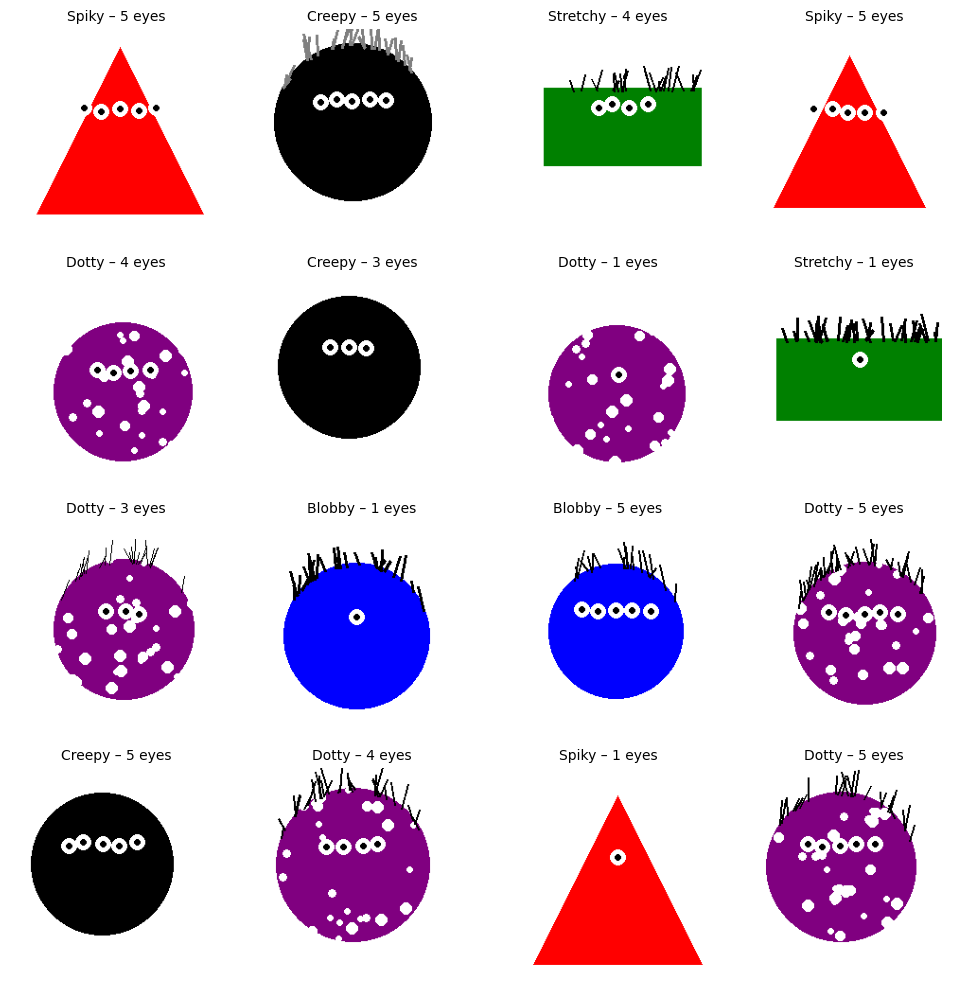

In [2]:
# Random preview of 16 training monsters with borders

import json
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Reproducible randomness (optional)
RANDOM_SEED = 43
random.seed(RANDOM_SEED)

# Dataset paths
DATA_DIR = Path("./monster_data")
TRAIN_JSONL = DATA_DIR / "train.jsonl"

# Load all training records
with open(TRAIN_JSONL, "r", encoding="utf-8") as f:
    records = [json.loads(line) for line in f]

# Sample 16 random records
samples = random.sample(records, k=min(16, len(records)))

# Create 4x4 plot
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for ax, record in zip(axes, samples):
    img = Image.open(record["image_path"]).convert("RGB")
    ax.imshow(img)
    ax.set_title(
        f'{record["monster_type"]} – {record["num_eyes"]} eyes',
        fontsize=10,
    )
    ax.axis("off")

    # Draw border around image
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor("black")

# Hide unused axes (if dataset has <16 items)
for ax in axes[len(samples):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


# Understanding the JSONL format

In [3]:
from pathlib import Path

TRAIN_JSONL = Path("./monster_data/train.jsonl")

print("".join(TRAIN_JSONL.read_text(encoding="utf-8").splitlines(True)[:5]))

{"image_path": "/home/juebrauer/src/examples/008_vlm_finetuning_with_unsloth_monsters/monster_data/train/0001_Blobby_1eyes_nohair.png", "monster_type": "Blobby", "num_eyes": 1, "has_hair": false, "question": "Describe the monster in the image.", "answer": "A monster of type Blobby with 1 eyes without hair"}
{"image_path": "/home/juebrauer/src/examples/008_vlm_finetuning_with_unsloth_monsters/monster_data/train/0002_Creepy_4eyes_hair.png", "monster_type": "Creepy", "num_eyes": 4, "has_hair": true, "question": "Describe the monster in the image.", "answer": "A monster of type Creepy with 4 eyes with hair"}
{"image_path": "/home/juebrauer/src/examples/008_vlm_finetuning_with_unsloth_monsters/monster_data/train/0003_Spiky_2eyes_nohair.png", "monster_type": "Spiky", "num_eyes": 2, "has_hair": false, "question": "Describe the monster in the image.", "answer": "A monster of type Spiky with 2 eyes without hair"}
{"image_path": "/home/juebrauer/src/examples/008_vlm_finetuning_with_unsloth_monst

In [4]:
import json
from pathlib import Path

TRAIN_JSONL = Path("./monster_data/train.jsonl")

with open(TRAIN_JSONL, "r", encoding="utf-8") as f:
    for i in range(5):
        obj = json.loads(f.readline())
        print(json.dumps(obj, indent=2, ensure_ascii=False))
        print("-" * 40)


{
  "image_path": "/home/juebrauer/src/examples/008_vlm_finetuning_with_unsloth_monsters/monster_data/train/0001_Blobby_1eyes_nohair.png",
  "monster_type": "Blobby",
  "num_eyes": 1,
  "has_hair": false,
  "question": "Describe the monster in the image.",
  "answer": "A monster of type Blobby with 1 eyes without hair"
}
----------------------------------------
{
  "image_path": "/home/juebrauer/src/examples/008_vlm_finetuning_with_unsloth_monsters/monster_data/train/0002_Creepy_4eyes_hair.png",
  "monster_type": "Creepy",
  "num_eyes": 4,
  "has_hair": true,
  "question": "Describe the monster in the image.",
  "answer": "A monster of type Creepy with 4 eyes with hair"
}
----------------------------------------
{
  "image_path": "/home/juebrauer/src/examples/008_vlm_finetuning_with_unsloth_monsters/monster_data/train/0003_Spiky_2eyes_nohair.png",
  "monster_type": "Spiky",
  "num_eyes": 2,
  "has_hair": false,
  "question": "Describe the monster in the image.",
  "answer": "A monster 

# Finetune a VLM using unsloth on the monster dataset

In [5]:
# 1. Prepare a VLM foundation model 
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",
    "unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

# Define the model to be used in the following here:
#modelname = "unsloth/gemma-3-4b-pt"
modelname = "unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit"

# This will download the model automatically if it has not been downloaded before
# Then the model will be loaded to RAM
model, tokenizer = FastVisionModel.from_pretrained(
    modelname,
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-12-31 08:00:49.074373: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-31 08:00:49.107544: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-31 08:00:49.956604: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/juebrauer/miniconda3/envs/env_teaching/lib/python3.12

🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.12.9: Fast Qwen3_Vl patching. Transformers: 4.57.3.
   \\   /|    NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition. Num GPUs = 1. Max memory: 94.969 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# 2. Prepare to finetune the model
#    by preparing a version of the model with a Lora adapter
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [7]:
# 3. Prepare conversation format for the VLM finetuning
import json

def read_jsonl(path):
    out = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            out.append(json.loads(line))
    return out

train_records = read_jsonl("./monster_data/train.jsonl")
test_records  = read_jsonl("./monster_data/test.jsonl")

instruction = "Describe the monster in the image."

def convert_to_conversation(sample):
    return {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": instruction},
                    {"type": "image", "image": sample["image_path"]},
                ],
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": sample["answer"]},
                ],
            },
        ]
    }

converted_train = [convert_to_conversation(s) for s in train_records]
converted_test  = [convert_to_conversation(s) for s in test_records]


In [8]:
len(converted_train), len(converted_test)

(450, 50)

In [9]:
converted_train[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text', 'text': 'Describe the monster in the image.'},
    {'type': 'image',
     'image': '/home/juebrauer/src/examples/008_vlm_finetuning_with_unsloth_monsters/monster_data/train/0001_Blobby_1eyes_nohair.png'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'A monster of type Blobby with 1 eyes without hair'}]}]}

In [10]:
# 4. # This is Gemma-3 specific and not necessary, e.g., for Qwen models
print(f"We fill finetune a {modelname} in the following...")

if "gemma" in modelname:

    from unsloth import get_chat_template

    tokenizer = get_chat_template(
        tokenizer,
        "gemma-3"
    )

We fill finetune a unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit in the following...


In [11]:
# 5. Check whether the model already knows the monster classes!

import json
from PIL import Image
from transformers import TextStreamer

records = read_jsonl("./monster_data/train.jsonl")

FastVisionModel.for_inference(model)  # Enable for inference!

sample = records[3]
image = Image.open(sample["image_path"]).convert("RGB")

instruction = "Describe the monster and the number of eyes in the image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction},
    ]}
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

text_streamer = TextStreamer(tokenizer, skip_prompt=True)

print("GT:", sample["answer"])
print("IMG:", sample["image_path"])

_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=64,
    use_cache=True,
    temperature=0.7,
)


GT: A monster of type Creepy with 2 eyes without hair
IMG: /home/juebrauer/src/examples/008_vlm_finetuning_with_unsloth_monsters/monster_data/train/0004_Creepy_2eyes_nohair.png
Based on the image provided, here is a description of the monster and the number of eyes:

The image depicts a simple, stylized monster that is circular and entirely black, set against a white background. It has a very minimalistic and cartoonish design. The only features visible are two small, white, circular eyes


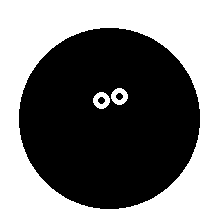

In [12]:
image

In [13]:
# 6. Now, finetune the model on the monster dataset!
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_train,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        #max_steps = 100, # for a quick training the nr of training steps can be limited with this option
        num_train_epochs = 2, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

trainer_stats = trainer.train()

Unsloth: Model does not have a default image size - using 512


The model is already on multiple devices. Skipping the move to device specified in `args`.


GPU = NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition. Max memory = 94.969 GB.
7.738 GB of memory reserved.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 450 | Num Epochs = 2 | Total steps = 114
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,346,944 of 8,818,470,640 (0.58% trained)


Step,Training Loss
1,5.072300
2,5.056000
3,4.978100
4,4.604900
5,4.133400
6,3.505700
7,2.724000
8,2.168900
9,1.803800
10,1.510200


In [14]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

125.9709 seconds used for training.
2.1 minutes used for training.
Peak reserved memory = 8.121 GB.
Peak reserved memory for training = 0.383 GB.
Peak reserved memory % of max memory = 8.551 %.
Peak reserved memory for training % of max memory = 0.403 %.


In [15]:
modelname

'unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit'

In [16]:
ADAPTERDIR_SAVE_NAME = "lora_adapter_" + modelname.replace("/", "_")
ADAPTERDIR_SAVE_NAME

'lora_adapter_unsloth_Qwen3-VL-8B-Instruct-unsloth-bnb-4bit'

In [17]:
model.save_pretrained(ADAPTERDIR_SAVE_NAME)
tokenizer.save_pretrained(ADAPTERDIR_SAVE_NAME)

[]

# Reload the model and test it on new data

In [19]:
# Reload the model or use the model from memory?
if True:

    # Reload the finetuned VLM
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = ADAPTERDIR_SAVE_NAME, # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!


# Load the test dataset meta information
records = read_jsonl("./monster_data/test.jsonl")

FastVisionModel.for_inference(model)  # Enable for inference!

for sample_idx in range(0,10):

    sample = records[sample_idx]
    image = Image.open(sample["image_path"]).convert("RGB")

    instruction = "Describe the monster and the number of eyes in the image."

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ]}
    ]

    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt=True)

    print("GT:", sample["answer"])
    #print("IMG:", sample["image_path"])

    _ = model.generate(
        **inputs,
        streamer=text_streamer,
        max_new_tokens=64,
        use_cache=True,
        temperature = 0.7
    )

    print("-" * 50) 

==((====))==  Unsloth 2025.12.9: Fast Qwen3_Vl patching. Transformers: 4.57.3.
   \\   /|    NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition. Num GPUs = 1. Max memory: 94.969 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GT: A monster of type Blobby with 3 eyes with hair
A monster of type Blobby with 3 eyes with hair<|im_end|>
--------------------------------------------------
GT: A monster of type Dotty with 4 eyes without hair
A monster of type Dotty with 4 eyes without hair<|im_end|>
--------------------------------------------------
GT: A monster of type Blobby with 1 eyes with hair
A monster of type Blobby with 1 eyes with hair<|im_end|>
--------------------------------------------------
GT: A monster of type Spiky with 2 eyes without hair
A monster of type Spiky with 2 eyes without hair<|im_end|>
--------------------------------------------------
GT: A monster of type Stretchy with 4 eyes without hair
A monster of type Stretchy with 4 eyes without hair<|im_end|>
--------------------------------------------------
GT: A monster of type Creepy with 2 eyes with hair
A monster of type Creepy with 2 eyes with hair<|im_end|>
--------------------------------------------------
GT: A monster of type Stretc